In [29]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.nn import ModuleList
from IPython.display import Audio
from torch.autograd import Variable
%matplotlib inline 


In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


**Function to convert input into One Hot vector**




In [33]:
class OneHot(nn.Module):
    def __init__(self, MU):
        super(OneHot,self).__init__()
        self.MU = MU
        self.ones = torch.sparse.torch.eye(MU).to(device)
    def forward(self, x):
        x = x.to(device)
        return Variable(self.ones.index_select(0,x.data)).to(device)
    def __repr__(self):
        return self.__class__.__name__ + "({})".format(self.MU)

**Defining Wavenet**

In [34]:
class Wavenet(nn.Module):
  def __init__(self,dilation_depth, n_blocks, n_dil_channnels, n_residual_channels,n_skip_channels, n_category, kernel_size):
    super(Wavenet,self).__init__()
    self.dilation_depth = dilation_depth
    self.n_blocks = n_blocks
    self.n_dil_channnels = n_dil_channnels
    self.n_residual_channels = n_residual_channels
    self.n_skip_channels = n_skip_channels
    self.n_category = n_category
    self. kernel_size = kernel_size
    self.One_hot = OneHot(n_category)
    
    ###Building the model###
    self.dilations = [2**i for i in range(dilation_depth)] * n_blocks

    self.filter_convs = nn.ModuleList()
    self.gate_convs = nn.ModuleList()
    self.residual_convs =nn.ModuleList()
    self.skip_convs = nn.ModuleList()

    ##creating first channels##
    self.input_convs = nn.Conv1d(in_channels = self.n_category, out_channels = self.n_residual_channels,kernel_size = 1)
    ###Creating wavenet blocks stacks###
    for d in self.dilations:
      self.filter_convs.append(nn.Conv1d(in_channels = n_residual_channels,out_channels = n_dil_channnels,kernel_size = kernel_size,dilation = d))
      self.gate_convs.append(nn.Conv1d(in_channels = n_residual_channels,out_channels = n_dil_channnels,kernel_size = kernel_size, dilation = d))
      self.residual_convs.append(nn.Conv1d(in_channels = n_dil_channnels,out_channels = n_residual_channels,kernel_size = 1))
      self.skip_convs.append(nn.Conv1d(in_channels = n_dil_channnels,out_channels = n_skip_channels,kernel_size = 1))
    ##post convoluions
    self.post_conv1 = nn.Conv1d(in_channels=n_skip_channels, out_channels = n_skip_channels,kernel_size=1)
    self.post_conv2  =nn.Conv1d(in_channels=n_skip_channels, out_channels = n_category, kernel_size=1)

  def forward(self, x):
    x.to(device)
    x = self.One_hot(x).unsqueeze(0).transpose(1,2)
    ### shape of x [batch_size, n_category, seq_len]
    x = self.input_convs(x) ### shape [batch_size, n_category, n_residual]
    skip_con = 0
    for i in range(self.dilation_depth*self.n_blocks):
      dilation = self.dilations[i]
      res = x
      filter = self.filter_convs[i](x)
      filter = torch.tanh(filter)
      gate = self.gate_convs[i](x)
      gate = torch.sigmoid(gate)
      x = filter*gate

      s = self.skip_convs[i](x)
      if skip_con is not 0:
        skip_con = skip_con[:,:,-s.size(2):]
      skip_con = s+skip_con
      x = self.residual_convs[i](x)
      x = x + res[:,:, dilation*(self.kernel_size-1):]
    x = torch.relu(skip_con)
    x = torch.relu(self.post_conv1(x))
    x = self.post_conv2(x)
    return torch.transpose(x.squeeze(0),0,1)
  ###Function to generate samples###
  def generate(self, input, num_samples=100):
        gen_list = input.data.tolist()
        for _ in range(num_samples):
            x = Variable(torch.LongTensor(gen_list[-sum(self.dilations)-1:]))
            y = self.forward(x)
            _, i = y.max(dim=1)
            gen_list.append(i.data.tolist()[-1])
        return gen_list


**Quantization of 16 bit audio**

In [35]:
def mulaw_quantize(x, qc):
    assert isinstance(x, torch.Tensor), 'mu_law_encoding expects a Tensor'
    mu = qc - 1
    if not x.is_floating_point():
        x = x.to(torch.float)
    mu = torch.tensor(mu, dtype=x.dtype)
    x_mu = torch.sign(x) * torch.log1p(mu *
                                       torch.abs(x)) / torch.log1p(mu)
    x_mu = ((x_mu + 1) / 2 * mu + 0.5).to(torch.int64)
    return x_mu

**Inverse quantization**

In [36]:
def inv_mulaw_quantize(x_mu, quantization_channels=256, device = device):
    mu = quantization_channels - 1.
    if isinstance(x_mu, np.ndarray):
        x = ((x_mu) / mu) * 2 - 1.
        x = np.sign(x) * (np.exp(np.abs(x) * np.log1p(mu)) - 1.) / mu
    elif isinstance(x_mu, (torch.Tensor, torch.LongTensor)):
        if isinstance(x_mu, (torch.LongTensor, torch.cuda.LongTensor)):
            x_mu = x_mu.float()
        if cuda:
            mu = (torch.FloatTensor([mu]))
        else:
            mu = torch.FloatTensor([mu])
        x = ((x_mu) / mu) * 2 - 1.
        x = torch.sign(x) * (torch.exp(torch.abs(x) * torch.log1p(mu)) - 1.) / mu
    return x

**Import torchaudio to load the audio file**

In [37]:
!pip install torchaudio 
# !pip install git+git://github.com/pytorch/audio
import torchaudio
import os


**Loading the data**

In [38]:
data, sr  = torchaudio.load('/content/data.wav')

**Building an instance of Wavenet**

In [39]:
dilation_depth = 10
n_blocks = 2
n_dilation_channels = 24
n_residual_channels = 24
n_skip_channels = 128
n_category = 128
kernel_size = 2
model = Wavenet(dilation_depth,n_blocks,n_dilation_channels ,n_residual_channels,n_skip_channels,n_category,kernel_size)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'The model has {count_parameters(model):,} trainable parameters')
model.to(device)

The model has 159,160 trainable parameters


Wavenet(
  (One_hot): OneHot(128)
  (filter_convs): ModuleList(
    (0): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
    (1): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(4,))
    (3): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(8,))
    (4): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(16,))
    (5): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(32,))
    (6): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(64,))
    (7): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(128,))
    (8): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(256,))
    (9): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(512,))
    (10): Conv1d(24, 24, kernel_size=(2,), stride=(1,))
    (11): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(2,))
    (12): Conv1d(24, 24, kernel_size=(2,), stride=(1,), dilation=(4,))
    (13): Conv1d(24, 24, kernel_size=(2,), s

**Define data generator**

In [40]:
def data_generation(data,fr,seq_len_segment , mu, device = device):
    ###shape of data is [batch_size,seq_len]
    ### we want to randomly choose a starting position and then extract the seq_len_segment
    ### now the data is normalized for mu law encoding
    max,_ = torch.max(data,1)
    min,_ = torch.min(data,1)
    if max>abs(min):
      data = torch.div(data,max)
    else:
      data = torch.div(data,abs(min))
    while True:
        start = np.random.randint(0,data.shape[1]-seq_len_segment)
        ys = data[:,start:start+seq_len_segment]
        ys = mulaw_quantize(ys,mu)
        ys = ys.squeeze(0)
        yield ys.to(device)

**Generate Data**

In [41]:
g = data_generation(data,sr,mu=128,seq_len_segment=20000,device = device)



**Visualize the data**

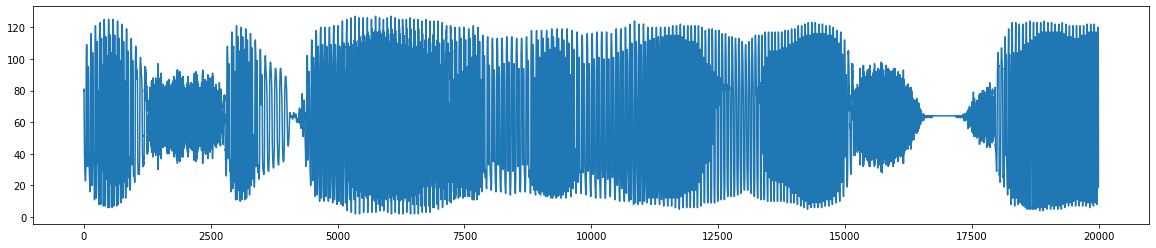

In [42]:
u = next(g)
u = u.data.tolist()
plt.figure(figsize=[20,4])
plt.plot(u)


**Listen to the audio segment**

In [43]:
y = np.array(u)
y = inv_mulaw_quantize(y, 128)
Audio(y,rate=16000)

**Optimizer and Loss Function**

In [44]:
from torch.optim import Adam
optimizer = Adam(params=model.parameters(), lr=0.01, eps=1e-8)
loss_function = nn.CrossEntropyLoss()

**Training Wavenet**

In [45]:
batch_size = 64
training_loss= []
epochs = 1000
for epoch in range(epochs):
    optimizer.zero_grad()
    train_loss = 0.0
    for _ in range(batch_size):
        optimizer.zero_grad()
        batch = next(g)
        x = batch[:-1]
        x = x.to(device)
        logits = model(x)
        t = logits.size(0)
        loss = loss_function(logits, batch[-t:])
        train_loss = train_loss+loss.item()
        
        loss.backward()
        optimizer.step()
    
    
    train_loss = train_loss/batch_size
    training_loss.append(loss)
    # # monitor at 100 epochs interval
    if epoch%100==0:
      print('epoch {}/{}, loss {}'.format(epoch,epochs, train_loss))

epoch 0/1000, loss 4.057684924453497
epoch 100/1000, loss 0.9191120071336627
epoch 200/1000, loss 0.37030544760636985
epoch 300/1000, loss 0.12684440449811518
epoch 400/1000, loss 0.3037854393478483
epoch 500/1000, loss 0.10348267745575868
epoch 600/1000, loss 0.2580848064972088
epoch 700/1000, loss 0.48762656887993217
epoch 800/1000, loss 0.04913475648208987
epoch 900/1000, loss 0.2632228030124679


**Plot training losses**

In [47]:
def plot_losses(trainLoss,Epochs):
    Epoch = []
    for i in range(Epochs):
      Epoch.append(i)
    plt.figure(figsize=(20,10))
    plt.plot(trainLoss, '-bx')
    plt.xlabel('epoch')
    plt.ylabel('train_loss')
    plt.legend(['Training_loss'])
    plt.title('Loss vs. No. of epochs');
    plt.savefig('/content/drive/MyDrive/yelp/wavenet_final.png')

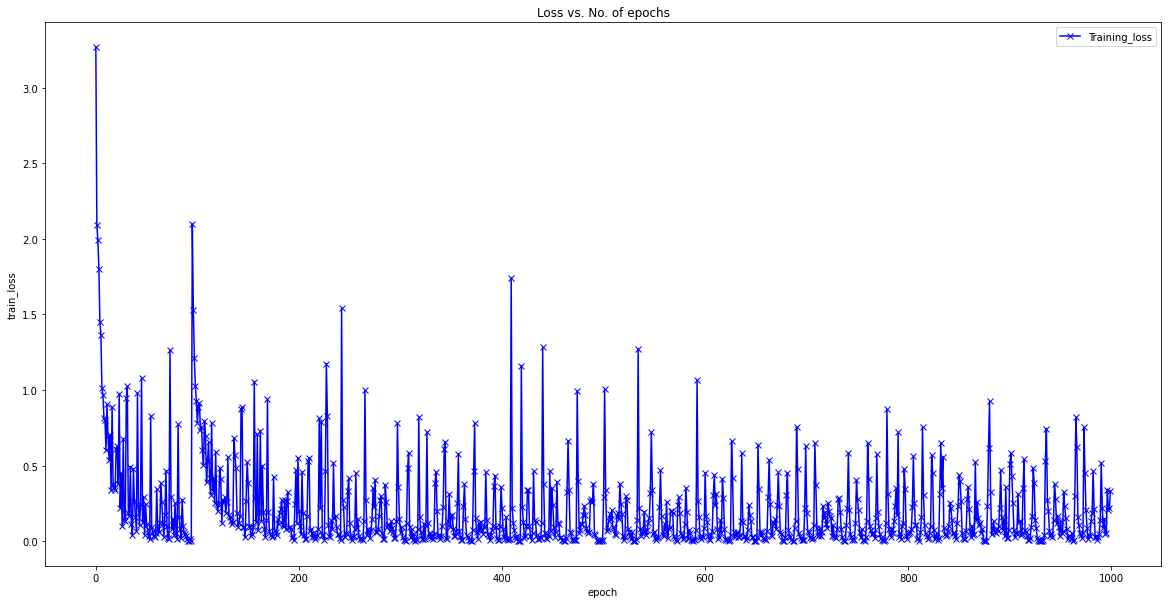

In [48]:
plot_losses(training_loss, epochs)

**Save the model**

In [54]:
model_name= 'wavenet_final.pt'
PATH = F"/content/drive/MyDrive/{model_name}"
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_train': training_loss
            
            }, PATH)
    

**Generate input data for give input to our trained Wavenet so that it can generate more samples**

In [55]:
def data_generation_sample(data, seq_len, mu, device):
    max,_ = torch.max(data,1)
    min,_ = torch.min(data,1)
    if max>abs(min):
      data = torch.div(data,max)
    else:
      data = torch.div(data,abs(min))
    start = 10
    ys = data[:,start:start+seq_len]
    ys = mulaw_quantize(ys,mu)
    ys = ys.squeeze(0)
    return ys.to(device)

In [75]:
input_data = data_generation_sample(data,mu=128, seq_len=4000,device = device)

print(input_data.shape)


torch.Size([4000])


In [52]:
checkpoint = torch.load('/content/drive/MyDrive/wavenet_final.pt')
model.load_state_dict(checkpoint['model_state_dict'])

**Generating audio samples using trained Wavenet**

In [76]:
generated_audio = model.generate(input_data, num_samples = 10000)
print(len(generated_audio))


14000


**Visualize the generated samples**

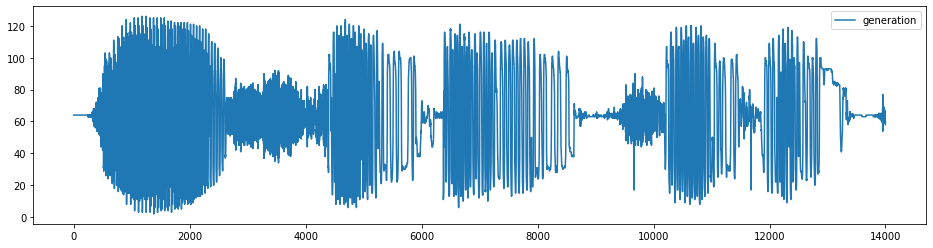

In [77]:
plt.figure(figsize=[16,4])
plt.plot(generated_audio)
# plt.plot(input_data.data.tolist(),'.',ms=2)
plt.legend(['generation','seed'])
plt.savefig('/content/drive/MyDrive/generateda_audio_final.png')


**Listen to the audio generated by wavenet and save it**

In [81]:
import soundfile
y = np.array(generated_audio)
print(y.shape)
y = inv_mulaw_quantize(y, 128)
Audio(y, rate=16000)
soundfile.write('/content/drive/MyDrive/generated_audio_final.wav',y,16000)

(14000,)
